# Pneumonia Normal Chest X-ray Classification

In [15]:
import keras
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense, Conv2D, MaxPooling2D, Flatten, Dropout, Input, Activation, ZeroPadding2D, BatchNormalization
from keras.optimizers import Adam
from sklearn.metrics import accuracy_score
import pandas as pd
import matplotlib.pyplot as plt

In [16]:
#building the neural net
model = Sequential()
model.add(Conv2D(32, (3,3), strides=(1,1), padding='same', input_shape=(64,64,1), activation='relu'))
model.add(Conv2D(32, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Conv2D(64, (3,3), strides=(1,1), padding='same', activation='relu'))
model.add(BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.25))

model.add(Flatten())
model.add(Dense(1024, activation='relu'))
model.add(BatchNormalization())
model.add(Dropout(0.40))
model.add(Dense(2, activation='softmax'))

In [17]:
#variable for Image Generator to read from separate files 
gen = ImageDataGenerator()

In [18]:
#from files load shape, set color to grayscale, shuffle images for seed, batch size
train_batches = gen.flow_from_directory("chest_xray/pandc/train",model.input_shape[1:3],color_mode="grayscale",shuffle=True,seed=1,
                                        batch_size=16)
valid_batches = gen.flow_from_directory("chest_xray/pandc/val", model.input_shape[1:3],color_mode="grayscale", shuffle=True,seed=1,
                                        batch_size=16)
test_batches = gen.flow_from_directory("chest_xray/pandc/test", model.input_shape[1:3], shuffle=False,
                                       color_mode="grayscale", batch_size=8)

Found 4123 images belonging to 2 classes.
Found 16 images belonging to 2 classes.
Found 435 images belonging to 2 classes.


In [19]:
#compile the model
model.compile(Adam(lr=0.001),loss="categorical_crossentropy", metrics=["accuracy"])

In [20]:
#class imbalance
#create weights for class imbalance
import numpy as np
COUNT_CORONA=248
COUNT_NORMAL=1341
TRAIN_IMG_COUNT=COUNT_NORMAL+COUNT_CORONA
#initial_bias = np.log([COUNT_PNEUMONIA/COUNT_NORMAL])
#initial_bias
weight_for_0 = (1 / COUNT_NORMAL)*(TRAIN_IMG_COUNT)/2.0 
weight_for_1 = (1 / COUNT_CORONA)*(TRAIN_IMG_COUNT)/2.0

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.59
Weight for class 1: 3.20


In [21]:
#fit the model
hist=model.fit(train_batches,validation_data=valid_batches,epochs=30, steps_per_epoch=16, validation_steps=1, class_weight=class_weight)

Epoch 1/30
16/16 [==============================] - 7s 426ms/step - loss: 0.9710 - accuracy: 0.6211 - val_loss: 33.9000 - val_accuracy: 0.5000
Epoch 2/30
16/16 [==============================] - 7s 412ms/step - loss: 0.5594 - accuracy: 0.6992 - val_loss: 4.0101 - val_accuracy: 0.5000
Epoch 3/30
16/16 [==============================] - 6s 352ms/step - loss: 0.3743 - accuracy: 0.7734 - val_loss: 10.2767 - val_accuracy: 0.5000
Epoch 4/30
16/16 [==============================] - 6s 383ms/step - loss: 0.2394 - accuracy: 0.8555 - val_loss: 0.3053 - val_accuracy: 0.8125
Epoch 5/30
16/16 [==============================] - 7s 467ms/step - loss: 0.1651 - accuracy: 0.9102 - val_loss: 0.9474 - val_accuracy: 0.5625
Epoch 6/30
16/16 [==============================] - 7s 412ms/step - loss: 0.2223 - accuracy: 0.9297 - val_loss: 1.7944 - val_accuracy: 0.5000
Epoch 7/30
16/16 [==============================] - 6s 379ms/step - loss: 0.0981 - accuracy: 0.9727 - val_loss: 0.5895 - val_accuracy: 0.6875
Epoc

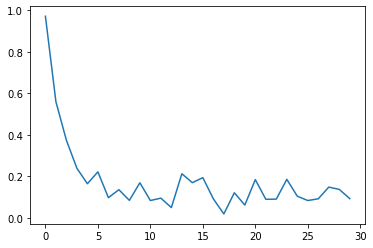

In [22]:
plt.plot(hist.history['loss'])

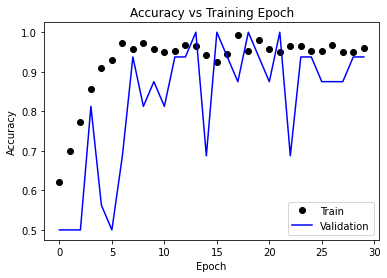

In [23]:
plt.plot(hist.history['accuracy'], 'ko')
plt.plot(hist.history['val_accuracy'], 'b')

plt.title('Accuracy vs Training Epoch')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(['Train', 'Validation']);

In [24]:
#predict on the model
no_steps = len(test_batches)
p = model.predict(test_batches, steps=no_steps, verbose=True)
pre = pd.DataFrame(p)

55/55 [==============================] - 5s 91ms/step


In [25]:
#class prediction results
pre["filename"] = test_batches.filenames
pre["label"] = (pre["filename"].str.contains("corona")).apply(int)
pre['pre'] = (pre[1]>0.5).apply(int)

In [26]:
accuracy_score(pre["label"], pre["pre"])

0.9586206896551724

In [30]:
from sklearn.metrics import recall_score
recall_score(pre["label"], pre["pre"], average=None)

array([0.96153846, 0.93333333])

In [31]:
from sklearn.metrics import f1_score
f1_score(pre["label"], pre["pre"], average=None)

array([0.9765625 , 0.82352941])

In [34]:
pre.tail(46)

,0,1,filename,label,pre
389,9.995114e-01,4.886362e-04,PNEUMONIA/person99_bacteria_474.jpeg,0,0
390,1.558776e-05,9.999844e-01,corona/D5ACAA93-C779-4E22-ADFA-6A220489F840.jpeg,1,1
391,1.560261e-01,8.439739e-01,corona/D7AF463C-2369-492D-908D-BE1911CCD74C.jpeg,1,1
392,8.784177e-07,9.999992e-01,corona/E1724330-1866-4581-8CD8-CEC9B8AFEDDE.jpeg,1,1
393,2.973034e-06,9.999970e-01,corona/F4341CE7-73C9-45C6-99C8-8567A5484B63.jpeg,1,1
394,6.793525e-05,9.999321e-01,corona/FE9F9A5D-2830-46F9-851B-1FF4534959BE.jpeg,1,1
395,1.077912e-01,8.922088e-01,corona/RX-torace-a-letto-del-paziente-in-unica...,1,1
396,1.773541e-03,9.982265e-01,corona/covid-19-pneumonia-101.png,1,1
397,6.678758e-07,9.999993e-01,corona/covid-19-pneumonia-35-1.jpg,1,1
398,1.203478e-02,9.879652e-01,corona/covid-19-pneumonia-35-2.jpg,1,1


In [33]:
pre.to_csv('PCresults.csv')

In [35]:
zero=pre.loc[pre['label'] == 0]
zero['pre'].value_counts()

0    375
1     15
Name: pre, dtype: int64